# Yeezy Taught Me - Analysis, dimensionality reduction, and clustering of audio features

Alex Chavez

General Assembly: Data Science (Summer 2016)

## Chop up the beats Kanye!

![Chop up the beats Kanye](assets/images/chop-up-the-beats-kanye.jpg)

# Project Imports

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

Pretty charts:

In [7]:
plt.style.use('fivethirtyeight')

# Dataset Overview

As the entire Million Song Dataset comes in at 300 GB and I do not currently have the infrastructure in place to handle the full set of data yet, I will be using the Million Song Subset for the exploratory analysis phase of the project.

The Million Song Subset consists of 10,000 songs (1%, 1.8 GB) selected at random.

The above song_features_df dataframe was the result of joining all the H5 files from the Million Song Dataset (MSD) subset using the ETL script triggered by the `make data_subset` command and other clean up operations performed in a clean up notebook.

## Data Clean Up 

In summary, the following data clean up operations were performed:
- Read all H5 files for a song where the artist's terms are of "alternative rap", "black", "east coast rap", "gangsta", "hip hop", "rap", and "soul". These are hand-picked terms from the set of Kanye West songs that I felt were the most relevant for pulling in similair artists to Kanye West.
- Appended audio features from the H5 files with artist metadata from the official MSD into a master pandas DataFrame
- Added `is_kanye_song` to easily filter for Ye songs
- Additional features were created by the length of the beats, bars, sections segments, and tatums array columns:
    - total_beats
    - total_bars
    - total_sections
    - total_segments
    - total_tatums

## Import Data

In [8]:
song_features_df = pd.read_pickle('../data/processed/msd_subset_song_features_clean_df.pkl')

# Data Analysis Summary

## Feature Densities

For our audio features, let's see how the values are distributed.

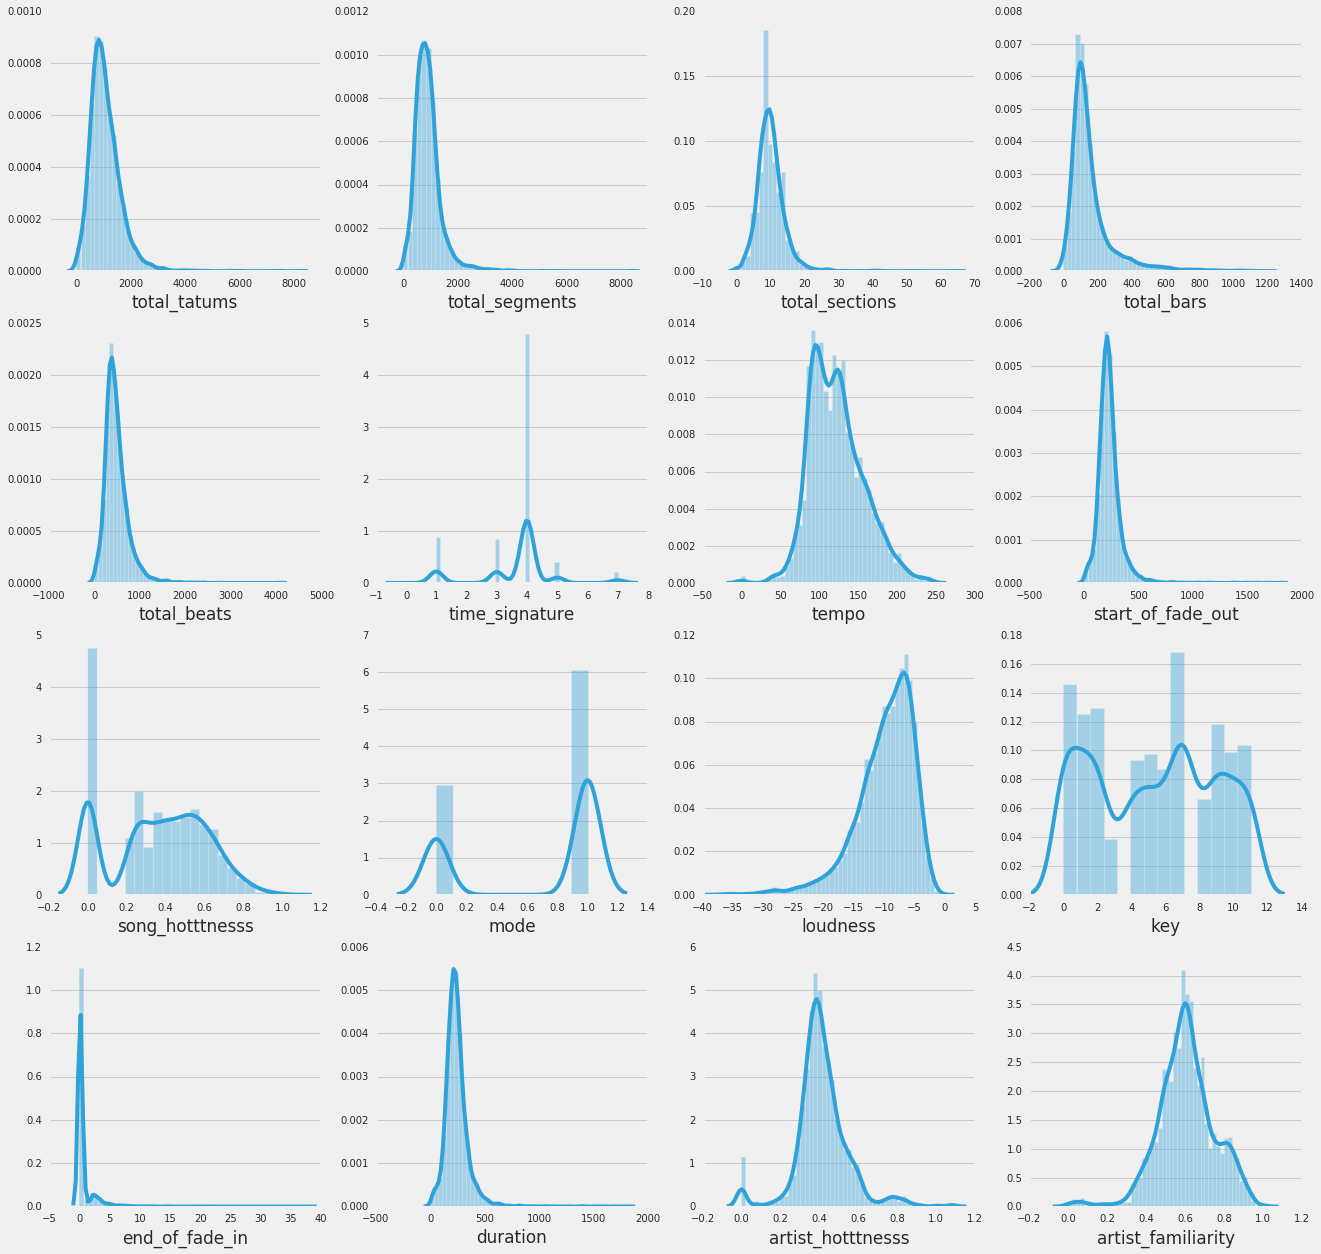

In [9]:
num_rows = 4
num_cols = 4

cols_to_plot = ['artist_familiarity', 'artist_hotttnesss', 'duration',
                'end_of_fade_in', 'key', 'loudness',
                'mode', 'song_hotttnesss', 'start_of_fade_out',
                'tempo', 'time_signature', 'total_beats',
                'total_bars', 'total_sections', 'total_segments',
                'total_tatums']


f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), sharex=False)

for i in range(num_rows):
    for j in range(num_cols):
        if len(cols_to_plot) != 0:
            var = cols_to_plot.pop()
            data = song_features_df[var].dropna()
            if data.dtype == np.ndarray:
                data = data.map(len)
            ax = sns.distplot(data, ax=axes[i, j])
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

### Takeaways

Looks interesting, but without knowing what to expect, it's hard to say if there's is any value of looking at the distribution and densities of the song features at face value. However, we at least know that the distributions of most feature values are not necessarily guassian or uni-modal, and that several only exist on a discrete scale (e.g. `key`, `mode`, and `time_signature`).

# Principal Component Analysis (PCA)

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), also known as Latent Semantic Indexing (LSI), is a common dimensionality reduction technique that finds the principal components of data. Instead of trying to find patterns in data for all our audio features we can instead use PCA to reduce the feature space into a subspace of fewer dimensions in which the data lies.

![PCA explained figuere](assets/images/fig_pca_principal_component_analysis.png)

## Using PCA

So, what can we do with the above features instead? Let's use PCA in order to emphasize variation and bring light to more subtle patterns in our audio features dataset.

In [10]:
import sklearn
from sklearn import decomposition

Let's get a subset of audio features we want to reduce.

In [11]:
cols_to_plot = ['artist_familiarity', 'artist_hotttnesss', 'duration',
                'end_of_fade_in', 'key', 'loudness',
                'mode', 'song_hotttnesss', 'start_of_fade_out',
                'tempo', 'time_signature', 'total_beats',
                'total_bars', 'total_sections', 'total_segments',
                'total_tatums']

features_to_consider = song_features_df[cols_to_plot].copy(deep=True)

Prep features that are not of type np.ndarray since pca.fit() does not like that.

In [12]:
mask = features_to_consider.dtypes != np.object
features_to_reduce = features_to_consider.loc[:, mask]
features_to_reduce = features_to_reduce.dropna()

Now run the PCA!

In [13]:
pca = decomposition.PCA(n_components=1)
pca.fit(features_to_reduce)
X = pca.transform(features_to_reduce)

### The explained variance ratio

In [14]:
print pca.explained_variance_ratio_

[ 0.8506337]


I initially used PCA to reduce my primary audio features down to four dimensions (or *principal components*). However, it appears that reducing it to one component captures most of the variance in the data.

PCA works by replacing our variables with new components which are orthogonal to the original. The PCA transformation returns a matrix `X` of orthogonal values. The orthogonal has variances (also called eigenvalues) that can be summed diagonally along the matrix to give us the explained variance ratio - which is 0.8506337 / 1.000 ~= **85.06% of the overall variability**.

## Visualizing the New Principal Component

Now that we have projected our features into a subspace of a one-dimensional line, we can easily make out which features stand out between the various songs.

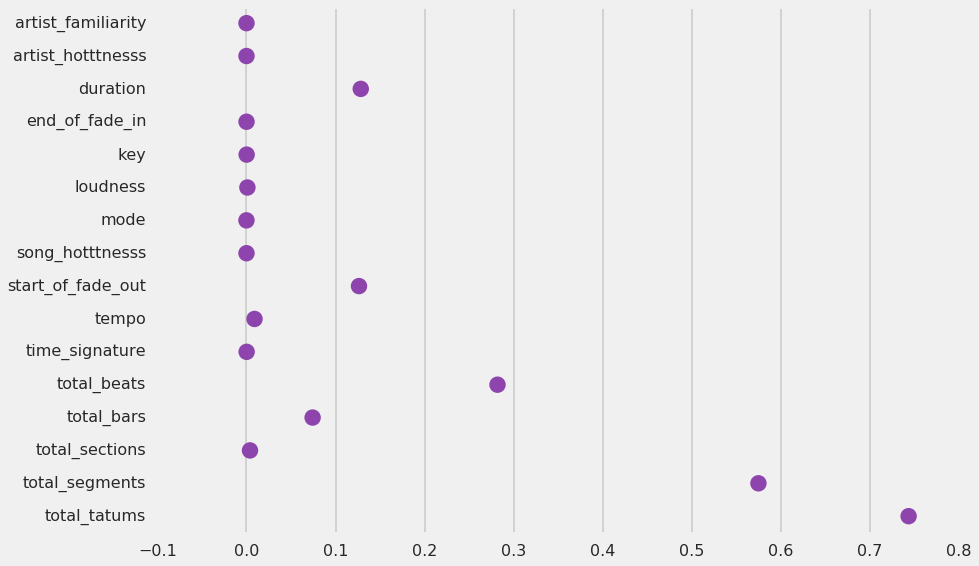

In [36]:
X1 = pca.components_[0] # our principal component

with plt.style.context('seaborn-poster'):
    sns.pointplot(x=X1, y=list(features_to_reduce.columns.values), join=False, color='#8e44ad')

### Takeaways

By plotting our principal component we see that there is significant variance for:

- duration
- start_of_fade_out
- total_beats
- total_bars
- total_segments
- total_tatums

We will use the above identified features in our model as they have the most variance. Furthermore, there isn't a good amount of variance for tempo, loudness, etc. as I would imagine most songs we pulled will naturally have many similar features in the genre of hip hop, rap, and soul.

# Clustering Songs Using K-Means

Next, we will use an unsupervised learning algorithm to discover groups of related artits using out audio features. Clustering is a common and fundamental example of unsupervised learning as it will try to find meaningful groups within data.

## What is K-Means Clustering?

K-Means clustering is a popular centroid-based clustering algorithm. The basic idea is to find `k` clusters in the data centrally located around various mean points. The algorithm seeks to minimize the sum of squares about the means.

The K-Means algorithm can be summarized by these steps:

1. Start with initial `k` mean values
1. Data points are split into a Voroni diagram
1. Assign each point to the "closest" mean
1. Calculate new means based on centroids
1. Repeat until clusters no longer change

![The K-Means clustering algorithm](assets/images/k-means-clustering-algorithm.png)

## Executing the K-Means Clustering Algorithm

Now that we know which features from our songs dataset have the most variance from our data points, we will use them in our clustering algorithm to group sets of related songs together.

In [16]:
features = [
    'duration',
    'start_of_fade_out',
    'tempo',
    'total_bars',
    'total_beats',
    'total_segments',
    'total_tatums'
]

Next let's run the K-Means implementation from scikit-learn to "discover" three groups using the above audio features.

In [55]:
from sklearn.cluster import KMeans

estimator = KMeans(n_clusters=3)
X = song_features_df[features]
estimator.fit(X)

# Clusters are given in the labels_ attribute
labels = estimator.labels_

# Save the identified cluster to our DataFrame
song_features_df['cluster'] = pd.Series(labels, index=song_features_df.index)

## Clustering Analysis

### What groups were discovered?

In [57]:
# Identified clusters
print Counter(labels)

Counter({1: 2399, 0: 1912, 2: 299})


### What Clusters did Ye show up in?

In [58]:
kanye_songs = song_features_df[song_features_df['is_kanye_song'] == 1]

In [59]:
kanye_clusters = sorted(kanye_songs['cluster'].unique())
print kanye_clusters

[0, 1]


### How do these groups differentiate from each other?

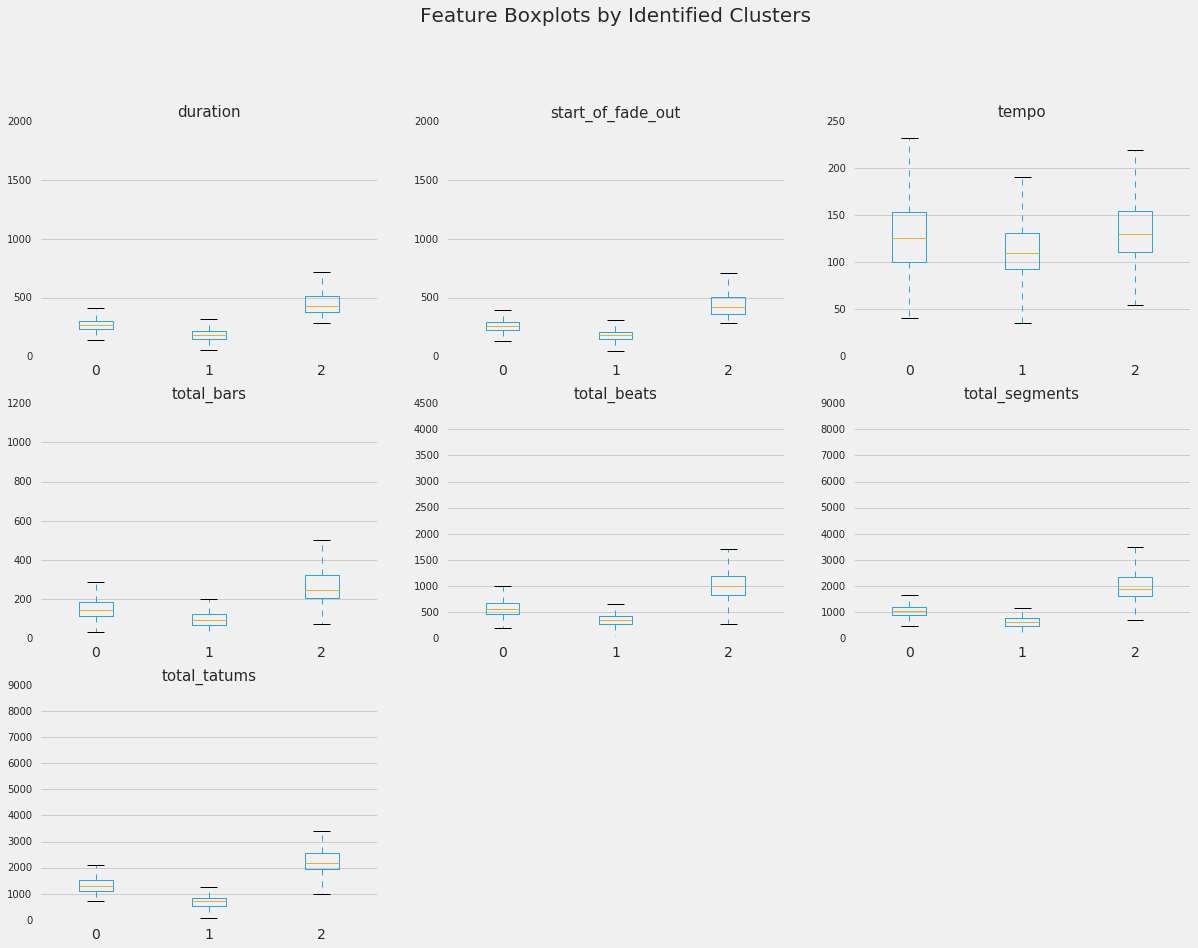

In [19]:
num_rows = 3
num_cols = 4

plt.figure(figsize=(20,20))

for i in range(len(features)):
    v = i + 1
    ax1 = song_features_df.boxplot(features[i], by='cluster', ax=plt.subplot(num_cols, num_rows, v))
    ax1.set_title(str(features[i]), fontsize=15)
    ax1.set_xlabel('')
    ax1.xaxis.grid(False)
    ax1.yaxis.grid(True)

plt.suptitle('Feature Boxplots by Identified Clusters', size=20)

### What songs are in these clusters?

Looking at box plots is pretty neat for data geeks, but doesn't tell us much of what K-Means clustering discovered. What songs are in our three identified clusters?

Print the top 15 songs for each cluster by artist popularity:

In [64]:
clusters = sorted(song_features_df['cluster'].unique())
for i in clusters:
    cluster_group = song_features_df[song_features_df['cluster'] == i]
    cluster_group = cluster_group[pd.notnull(cluster_group['artist_hotttnesss'])]
    cluster_group.sort_values(by='artist_hotttnesss', ascending=False, inplace=True)
    print 'Top 10 Songs (By Aritst Popularity) for Cluster %s' %i
    print
    print cluster_group[['artist_name', 'title', 'artist_hotttnesss']].head(15)
    print

Top 10 Songs (By Aritst Popularity) for Cluster 0

                             artist_name  \
324             Kanye West / Adam Levine   
1918                          Kanye West   
620   Kanye West / Consequence / Cam'Ron   
3687                          Kanye West   
4092                     Black Eyed Peas   
248       Black Eyed Peas / Terry Dexter   
314                              Rihanna   
4236                             Rihanna   
1580                             Rihanna   
1965                             Rihanna   
677                              Rihanna   
1699                             Rihanna   
4533                              Eminem   
3630                                T.I.   
4532                                T.I.   

                                             title  artist_hotttnesss  
324                                  Heard 'Em Say           1.082503  
1918                              Through The Wire           1.082503  
620                         

From the above data table we can see that Clusters {0, 1} have more hip hop and rap songs as expected. Cluster 2 has a lot of rock and pop songs that I presume were incorrectly tagged in our data set and came as an unexpected surprise.

In the above data table `artist_hotttnesss` corresponds to how much buzz the artist was getting back in 2010 when our Million Song Dataset - err subset, was created. This is derived from many sources, including mentions on the web, mentions in music blogs, music reviews, play counts, etc. The reason Kanye West tops the `artist_hotttnesss` for Cluters {0, 1} can be explained by his infamous incident with Taylor Swift in the 2009 MTV Video Music Awards.


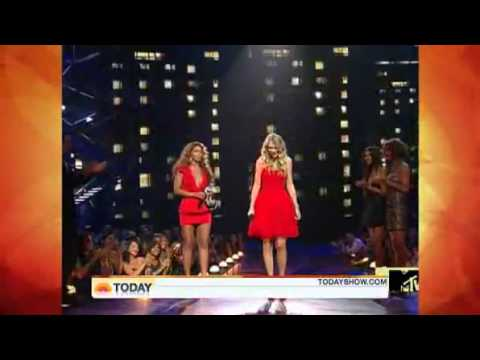

In [87]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start_point = int(timedelta(seconds=11).total_seconds())
YouTubeVideo("z4xWU8o2cvA", start=start_point, autoplay=0)

A Google Trends search for "Kanye West" reveals there was a peak of interest in September 2009 due to Kanye's highly publicized antics at the VMA's.

![Searching "Kanye West" on Google Trends](assets/images/kanye-google-trends.png)

### Clustering Metrics

In order to evaluate our model fit of our clustering algorithm we use a metric called the **Silhouette Coefficient**.

The Silhouette Coefficient is:

$ \frac{b - a}{\max \left (a, b \right )} $

It's calculated such that:

- **a** is the mean distance between a sample and all other points in the cluster
- **b** is the mean distance between a sample and all other points in the nearest cluster
- Ranges between -1 and 1
- Averages over all points to judge the classifier

### The Silhouette Coefficient

We can use the metrics module from scikit-learn to calculate the Silhouette Coefficient for our fitted K-Means estimator.

In [56]:
from sklearn import metrics
metrics.silhouette_score(X, labels, metric='euclidean')

0.40582969048900902

Silhoette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For three clusters, the **average silhouette score is 0.405**.

#### What happened?

# Calculating Similarity

In [ ]:
One approach to getting a list of artists that are similar to Kanye West we need to

1. Use normalization
2. Compute the cosine
3. Find the max

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between our
# subset of Ye songs and the rest of our songs
# dataset
X = kanye_songs[features]
Y = song_features_df[features]
similarity = cosine_similarity(X, Y)

# Store the cosine distance results in our dataframe
song_features_df['cosine_distance'] = similarity.T.tolist()

In [25]:
def get_max_cosine_distance(distances):
    max_distance = 0.0
    for idx, d in enumerate(distances):
        if d != 1.0 and d > max_distance:
            max_distance = d
    return max_distance

In [26]:
song_features_df['kanye_similarity'] = song_features_df['cosine_distance'].apply(get_max_cosine_distance)

In [27]:
song_features_df.head()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,...,year,is_kanye_song,total_beats,total_bars,total_sections,total_segments,total_tatums,cluster,cosine_distance,kanye_similarity
0,22050,7725,0.687687,0.406686,ARDI88R1187B98DAB2,NaN,,NaN,fd87374e-ffde-4d36-89a8-8a073f795666,[],...,0,0,346,86,10,934,692,1,"[0.970068379396, 0.969574050092, 0.99848643460...",0.998486
1,22050,74269,0.593416,0.395710,ARZEWUR1187FB53DC8,50.45663,"Belgica -- Namur, Namur/Ghent, East Flanders",4.87137,0be59867-0da4-4e45-9b64-728cdf25487c,[],...,2010,0,133,41,4,80,399,1,"[0.900495229203, 0.861901099299, 0.79970524644...",0.901623
2,22050,49956,0.815923,0.555138,ARUZRFN1187B98AC05,NaN,"Cleveland, OH",NaN,2fa45bbb-0efb-4950-9d40-94bf23cbfec1,[],...,2000,0,426,426,11,1131,1277,0,"[0.983257135391, 0.980153313475, 0.97383144873...",0.983257
3,22050,588,0.929030,0.750427,ARR3ONV1187B9A2F59,54.31407,UK,-2.23001,fd857293-5ab8-40de-b29e-55a69d4e4d0f,[],...,0,0,321,321,8,537,643,1,"[0.976021767005, 0.939130911945, 0.94717770319...",0.976022
4,22050,11301,0.645192,0.471224,AR3THYK1187B999F1F,NaN,,NaN,286ec4c2-b5ca-4f85-b331-280a6d73dd14,"[brazilian, south american, brazilian classics...",...,2000,0,403,100,10,616,806,1,"[0.999139927941, 0.97515753146, 0.973118516572...",0.999140


In [28]:
song_features_df['kanye_similarity'].min()

0.65132022229209352

In [29]:
song_features_df['kanye_similarity'].max()

1.0000000000000002

In [30]:
song_features_df['kanye_similarity'].describe()

count    4610.000000
mean        0.989253
std         0.018638
min         0.651320
25%         0.986343
50%         0.995858
75%         0.998303
max         1.000000
Name: kanye_similarity, dtype: float64

In [88]:
def get_top_matches(df):
    top_matches = df.groupby(['artist_name'])['kanye_similarity'].apply(np.max)
    top_matches = top_matches.sort_values(ascending=False)
    return top_matches.head(30)

In [90]:
print get_top_matches(song_features_df)

artist_name
Kanye West                    1.000000
Mista                         0.999987
Princess Lover                0.999983
Mykill Miers                  0.999983
Michael McDonald              0.999981
Brooke Valentine              0.999976
Dub Pistols feat. TK & JMS    0.999976
DJ Quik                       0.999974
The Winans                    0.999973
themselves                    0.999962
Leroy Hutson                  0.999961
Tha Chamba                    0.999960
Rakim feat. Tracey Horton     0.999956
Pete Philly & Perquisite      0.999954
OutKast                       0.999945
The Shamen                    0.999945
Eric Champion                 0.999941
Toni Braxton                  0.999940
Twista                        0.999937
Eminem                        0.999934
Lyrics Born                   0.999930
Johnny Osbourne               0.999929
Deodato                       0.999924
Walter Jackson                0.999922
5th Ward Boyz                 0.999914
Aesop Rock   

We know that Kanye West started off his music career as a producer. Ye became Jay-Z's go-to-producer after he produced a few songs for one of Hov's most well received albums - "The Blueprint".

Let's use the fact that Kanye West started to become known in the mainstream after his collaboration with Jay-Z in 2001.

In [92]:
clean_years = song_features_df[song_features_df['year'] >= 2001]
print get_top_matches(clean_years)

artist_name
Kanye West                                                     1.000000
Princess Lover                                                 0.999983
Brooke Valentine                                               0.999976
themselves                                                     0.999962
Rakim feat. Tracey Horton                                      0.999956
Twista                                                         0.999937
Aesop Rock                                                     0.999910
Sub Focus                                                      0.999909
Eddie                                                          0.999892
Deftones                                                       0.999885
Kirk Franklin                                                  0.999883
The Killers                                                    0.999878
Jay-Z                                                          0.999869
Bally Sagoo                                         

# Interpretation

Kanye West has in fact produced and collaborated for Twista, Fat Joe, Jay-Z, T.I., B.o.B, Beyonce, Rihana, Janet Jackson and more! By using the cosine distance metric with our audio features that were identified by our Principal Component Analysis, we got a good list of related artists. It's not perfect, but it's a good starting point!

## Songs Produced by Kanye

Twista (feat. Kanye West) - Overnight Celebrity:

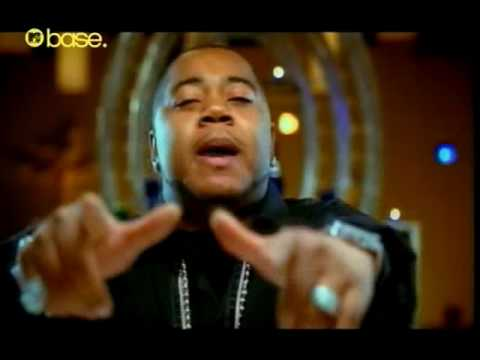

In [95]:
YouTubeVideo("TVpIOvpM5eU")

T.I. - Let Me Tell You Something:

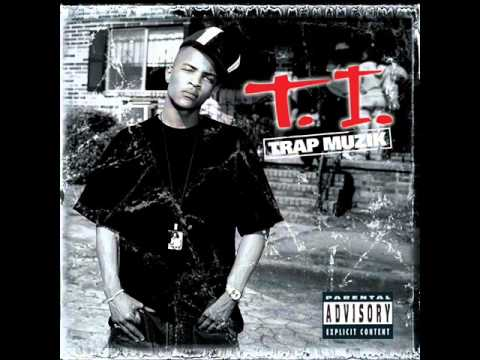

In [97]:
YouTubeVideo("VfDaemwo1NY")

Beyonce (feat. Kanye West) - Ego:

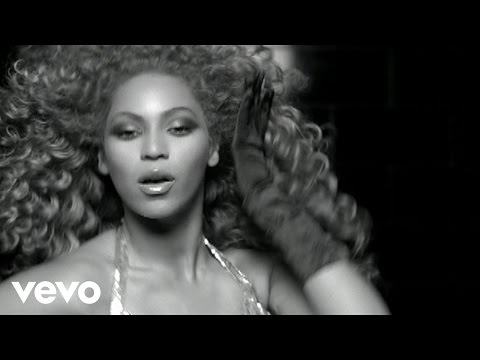

In [99]:
YouTubeVideo("iW5EzxFR4SM")

Ye and Hov making "Lucifer":

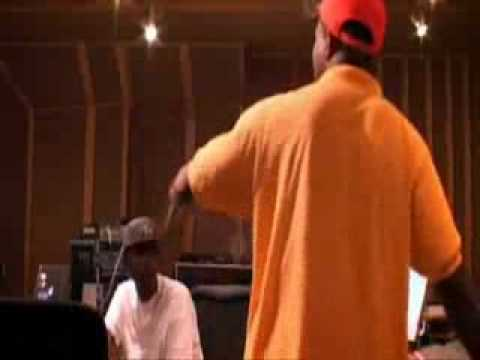

In [103]:
start_point = int(timedelta(minutes=1, seconds=54).total_seconds())
YouTubeVideo("PdyyNJcNavw", start=start_point, autoplay=0)

## Chimpmunk Soul

Yeezy is know in the music industry for his use of [Chimpmunk Soul](https://en.wikipedia.org/wiki/Chicago_hip_hop#.22Chipmunk_soul.22) sampling and pitching-up of soul vocals. It's pretty neat seeing Kirk Franklin make our list top most 30 similar artists to Kanye! Maybe something can be said of Kanye West influencing hip hop, rap, soul artists.

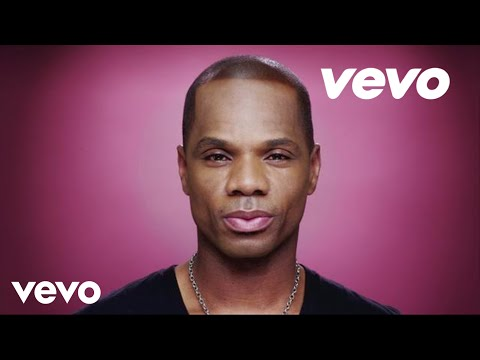

In [100]:
YouTubeVideo("Z8SPwT3nQZ8")

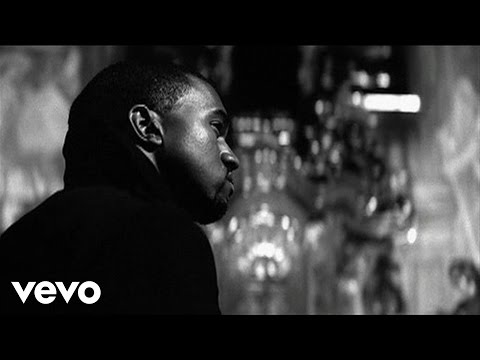

In [104]:
start_point = int(timedelta(seconds=57).total_seconds())
YouTubeVideo("92FCRmggNqQ", start=start_point, autoplay=0)

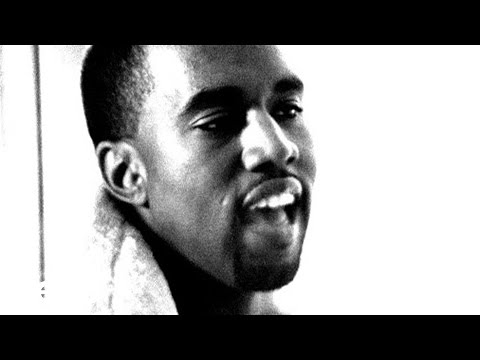

In [105]:
start_point = int(timedelta(seconds=20).total_seconds())
YouTubeVideo("elVF7oG0pQs", start=start_point, autoplay=0)